# Application of Classic Reservoir Computing via ESN

Author: Alvin B. Lin\
Last Update: 02/02/2026\
Reference: Platt, J. A., Penny, S. G., Hunt, B. R., & Kalnay, E. (2022). "A systematic exploration of reservoir computing for forecasting complex spatiotemporal dynamics." Chaos: An Interdisciplinary Journal of Nonlinear Science, 32(1).


## Introduction
The work by Platt et al. (2022) focuses on making Reservoir Computing a reliable tool for long-term forecasting of chaotic dynamical systems. The paper addresses the "black box" nature of traditional reservoirs by introducing systematic ways to optimise hyperparameters and measure physical accuracy.
### The Core Architecture
The paper utilises the Echo State Network (ESN) framework but emphasises the importance of the internal state evolution. The reservoir acts as a high-dimensional nonlinear filter that maps a low-dimensional input (the "shadow" of the system) into a high-dimensional space where the dynamics become linearly separable.
- **Linear Drive:** The input signal is projected into the reservoir via an input matrix $\mathbf{W}_{in}$.
- **Nonlinear Internal Dynamics:** The internal state $\mathbf{r}(t)$ evolves through a $\tanh$ activation function, creating the "Echo State Property" where the current state depends on a fading memory of previous inputs.
### The Methodology: Validation-Centric Training
The primary contribution of the Platt paper is the shift from simple MSE (Mean Squared Error) minimisation to Dynamical Consistency.
- **Hyperparameter Optimisation:** Rather than guessing, the paper suggests using **Bayesian Optimisation** to find the ideal values for the Spectral Radius ($\rho$), Input Scaling ($\sigma_{in}$), and Leaking Rate ($\alpha$).Ridge Regression (Tikhonov Regularisation): The output weights $\mathbf{W}_{out}$ are solved analytically. The paper highlights that the regularisation parameter $\beta$ is not just a "noise filter" but a tool to ensure the reservoir stays on the Synchronisation Manifold.
- **Valid Prediction Time (VPT):** Platt introduces a rigorous metric for success. A prediction is only "valid" as long as the normalised error remains below a specific threshold (typically $0.4$). This acknowledges that in chaos, bit-for-bit accuracy will always eventually fail.
### Key Findings and Advantages
- **Nonlinearity via Bias:** One of the most important takeaways from the paper is that adding a strong Input Bias ($\sigma_b \approx 1.0$) is critical for systems with sharp gradients (like the Lorenz system or heart waves). This "pushes" the reservoir into the nonlinear "elbows" of the activation function.
- **Model-Free Attractor Reconstruction:** The paper demonstrates that a well-tuned reservoir doesn't just predict numbers; it reconstructs the attractor geometry. Even after the time-series diverges (post-VPT), the model continues to follow a path that is topologically identical to the original system.
- **Sparsity and Speed:** By using sparse reservoir matrices (e.g., 1% connectivity), the model maintains high performance while reducing the computational overhead of the state updates.

## Algorithm
In this implementation, we do not perform **Bayesian Optimisation**, we mainly focus on the ESN predictions for several different models.

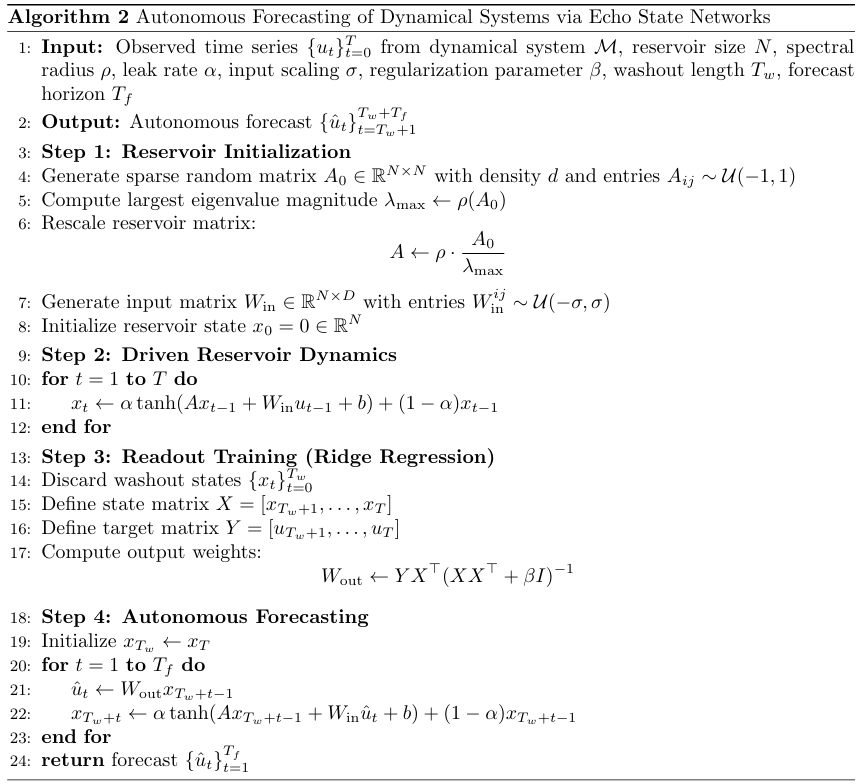

## Creating a Class for Prediction Convenience

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
from scipy.sparse import random as sprand
from scipy.sparse.linalg import eigs

class ESN:
    def __init__(
        self,
        D,
        N,
        SR,
        density,
        alpha,
        sigma,
        random_state=111111,
        b=0.0,
        beta=1e-12,
    ):
        """
        Echo State Network
        """
        self.D = D                      # Input dimension
        self.N = N                      # Reservoir dimension
        self.SR = SR                    # Spectral radius
        self.density = density          # Reservoir sparsity
        self.alpha = alpha              # Leak rate
        self.sigma = sigma              # Input scaling
        self.b = b                      # Bias
        self.beta = beta                # Ridge parameter

        self.rng = default_rng(random_state)

        self.A = self.get_connection_matrix()
        self.Win = self.rng.uniform(
            -self.sigma, self.sigma, size=(self.N, self.D)
        )
        self.Wout = np.zeros((self.D, self.N))

    def get_connection_matrix(self):
        """
        Create sparse reservoir matrix and scale spectral radius
        """
        def rvs(k):
            return self.rng.uniform(-1.0, 1.0, size=k)

        A = sprand(
            self.N, self.N,
            density=self.density,
            data_rvs=rvs,
            format="csr"
        )

        eigval = eigs(A, k=1, return_eigenvectors=False)
        maxeig = np.abs(eigval[0])

        A = A * (self.SR / maxeig)
        return A

    def driven_esn(self, rt, ut):
        """
        Reservoir update with input
        """
        pre = self.A @ rt + self.Win @ ut + self.b
        return self.alpha * np.tanh(pre) + (1 - self.alpha) * rt

    def auto_esn(self, rt):
        """
        Autonomous reservoir update
        """
        pre = self.A @ rt + self.Win @ (self.Wout @ rt) + self.b
        return self.alpha * np.tanh(pre) + (1 - self.alpha) * rt

    def generate(self, u):
        """
        Generate reservoir states
        """
        T = u.shape[1]
        r = np.zeros((self.N, T))

        for t in range(1, T):
            r[:, t] = self.driven_esn(r[:, t - 1], u[:, t - 1])

        return r

    def compute_Wout(self, r, u):
        """
        Train output weights using ridge regression
        """
        I = np.eye(self.N)
        self.Wout = (
            np.linalg.solve(
                r @ r.T + self.beta * I,
                r @ u.T
            ).T
        )

    def train_RC(self, u, spinup):
        """
        Train ESN
        """
        r = self.generate(u)
        self.compute_Wout(
            r[:, spinup:],
            u[:, spinup:]
        )

    def forecast_RC(self, nsteps, uspin=None, r0=None):
        """
        Forecast future values
        """
        if uspin is not None:
            rspin = self.generate(uspin)
            r0 = rspin[:, -1]

        assert r0 is not None

        rfc = np.zeros((self.N, nsteps))
        rfc[:, 0] = r0

        for t in range(nsteps - 1):
            rfc[:, t + 1] = self.auto_esn(rfc[:, t])

        return self.Wout @ rfc




def run_esn_on_system(
    system_name,
    system_rhs,
    x0,
    params,
    dt=0.01,
    T=6000,
    spinup=1500,
    esn_kwargs=None,
    forecast_steps=500,
    observed_idx=None,
):
    """
    Universal ESN experiment for arbitrary dynamical systems

    Parameters
    ----------
    system_name : str
        Name of the dynamical system
    system_rhs : callable
        f(x, t, params) -> dx/dt
    x0 : ndarray (d,)
        Initial condition
    params : dict
        Parameters passed to system_rhs
    dt : float
        Time step
    T : int
        Total simulation length
    spinup : int
        Washout length
    esn_kwargs : dict
        Arguments passed to ESN constructor
    forecast_steps : int
        Autonomous prediction length
    observed_idx : list or None
        Indices of observed components (default: all)

    Returns
    -------
    dict with data, prediction, ESN, metadata
    """

    # -----------------------------
    # 1. Simulate dynamical system
    # -----------------------------
    d = len(x0)
    x = np.zeros((d, T))
    x[:, 0] = x0

    for t in range(T - 1):
        x[:, t + 1] = x[:, t] + dt * system_rhs(
            x[:, t], t * dt, params
        )

    if observed_idx is None:
        observed_idx = list(range(d))

    u = x[observed_idx, :]

    # -----------------------------
    # 2. Normalize (critical!)
    # -----------------------------
    mean = u.mean(axis=1, keepdims=True)
    std = u.std(axis=1, keepdims=True)
    u_norm = (u - mean) / std

    # -----------------------------
    # 3. Create ESN
    # -----------------------------
    esn = ESN(
        D=u_norm.shape[0],
        **esn_kwargs
    )

    # -----------------------------
    # 4. Train
    # -----------------------------
    esn.train_RC(u_norm, spinup=spinup)

    # -----------------------------
    # 5. Forecast
    # -----------------------------
    u_spin = u_norm[:, :spinup]

    pred_norm = esn.forecast_RC(
        nsteps=forecast_steps,
        uspin=u_spin
    )

    pred = pred_norm * std + mean
    truth = u[:, spinup:spinup + forecast_steps]

    # -----------------------------
    # 6. Plot
    # -----------------------------
    plt.figure(figsize=(10, 4))
    plt.plot(truth[0], label="True")
    plt.plot(pred[0], "--", label="ESN")
    plt.title(f"{system_name} – ESN Prediction")
    plt.legend()
    plt.show()

    '''
    # -----------------------------
    # 7. Return everything
    # -----------------------------
    return {
        "system": system_name,
        "data": x,
        "truth": truth,
        "prediction": pred,
        "esn": esn,
        "params": params,
    }
    '''

## Test for Double Pendulum

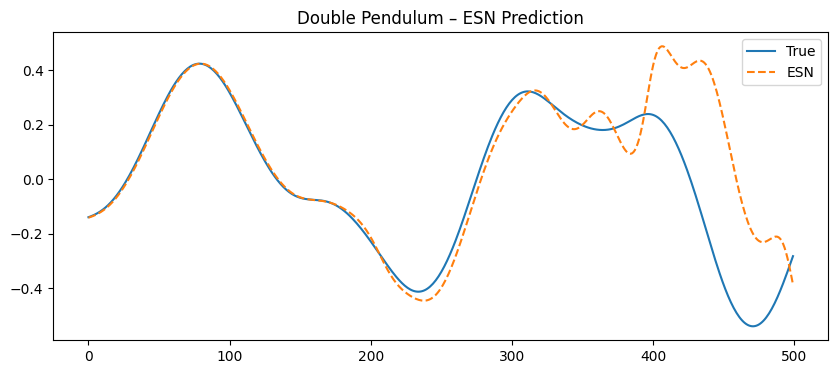

In [138]:
def double_pendulum_rhs(x, t, p):
    theta1, omega1, theta2, omega2 = x
    m1, m2, L1, L2, g = p.values()

    delta = theta2 - theta1

    denom1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta)**2
    denom2 = (L2 / L1) * denom1

    dtheta1 = omega1
    dtheta2 = omega2

    domega1 = (
        m2 * L1 * omega1**2 * np.sin(delta) * np.cos(delta)
        + m2 * g * np.sin(theta2) * np.cos(delta)
        + m2 * L2 * omega2**2 * np.sin(delta)
        - (m1 + m2) * g * np.sin(theta1)
    ) / denom1

    domega2 = (
        -m2 * L2 * omega2**2 * np.sin(delta) * np.cos(delta)
        + (m1 + m2) * g * np.sin(theta1) * np.cos(delta)
        - (m1 + m2) * L1 * omega1**2 * np.sin(delta)
        - (m1 + m2) * g * np.sin(theta2)
    ) / denom2

    return np.array([dtheta1, domega1, dtheta2, domega2])

run_esn_on_system(
    system_name="Double Pendulum",
    system_rhs=double_pendulum_rhs,
    x0=np.array([0.2, 0.0, 0.3, 0.0]),
    params={
        "m1": 1.0,
        "m2": 1.0,
        "L1": 1.0,
        "L2": 1.0,
        "g": 9.81
    },
    observed_idx=[0],  # only θ1
    esn_kwargs=dict(
        N=800,
        SR=0.95,
        density=0.03,
        alpha=0.2,
        sigma=0.4,
        beta=1e-8,
        random_state=0,
    ),
    T=2000,
    #forecast_steps=500
)


## Test for Lorenz63 System

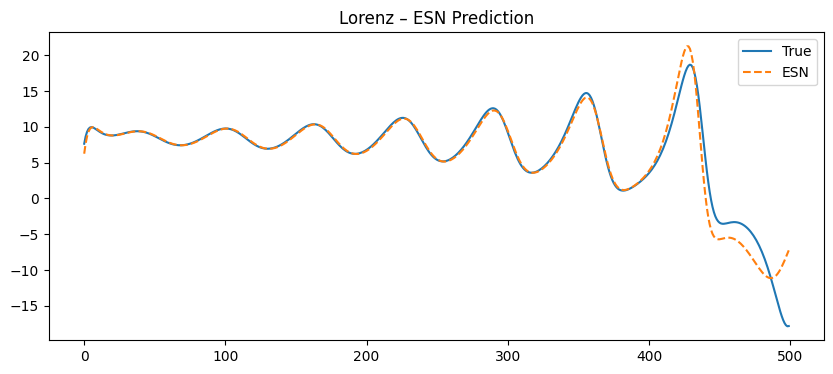

In [111]:
def lorenz(x, dt, p):
    """
    Simulate Lorenz system using Euler method
    """
    u, v, w = x
    sigma = p["sigma"]
    rho = p["rho"]
    beta = p["beta"]

    du = sigma * (v - u)
    dv = u * (rho - w) - v
    dw = u * v - beta * w

    return np.array([du, dv, dw])


run_esn_on_system(
    system_name="Lorenz",
    system_rhs=lorenz,
    x0=np.array([1.0, 1.0, 1.0]),
    params={
        "sigma": 10.0,
        "rho": 28.0,
        "beta": 8/3
    },
    observed_idx=[1],  # only x
    esn_kwargs=dict(
        N=2000,            # reservoir size
        SR=0.9,           # spectral radius
        density=0.02,     # sparsity
        alpha=0.3,        # leak rate
        sigma=0.5,        # input scaling
        beta=1e-8,        # ridge regularization
        random_state=42
    ),
    #dt=0.1,
    T=6400,
    forecast_steps=500
)

## Test for Predator Prey Model

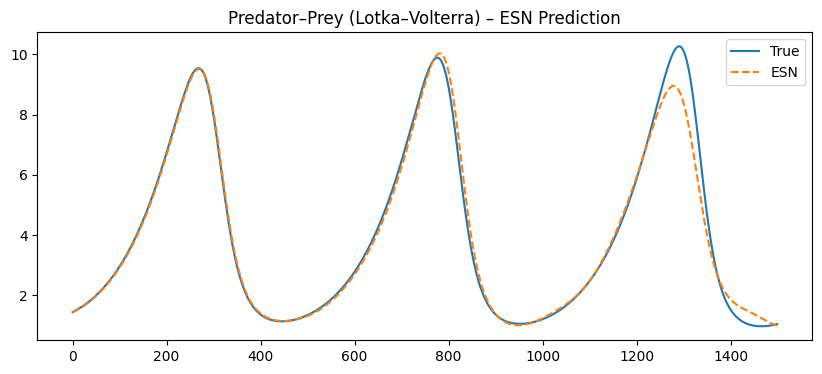

In [133]:
def predator_prey_rhs(x, t, p):
    """
    Lotka–Volterra predator–prey model

    x[0] = prey population
    x[1] = predator population
    """
    prey, predator = x

    alpha = p["alpha"]   # prey growth rate
    beta  = p["beta"]    # predation rate
    delta = p["delta"]   # predator reproduction
    gamma = p["gamma"]   # predator death rate

    dprey = alpha * prey - beta * prey * predator
    dpred = delta * prey * predator - gamma * predator

    return np.array([dprey, dpred])


result_pp = run_esn_on_system(
    system_name="Predator–Prey (Lotka–Volterra)",
    system_rhs=predator_prey_rhs,
    x0=np.array([1.5, 1.0]),
    params={
        "alpha": 1.0,
        "beta": 0.5,
        "delta": 0.5,
        "gamma": 2.0
    },
    dt=0.01,
    T=5000,
    spinup=500,
    observed_idx=[0],   # prey + predator
    esn_kwargs=dict(
        N=1000,
        SR=0.8,
        density=0.05,
        alpha=0.3,
        sigma=0.4,
        beta=1e-8,
        random_state=42,
    ),
    forecast_steps=1500
)


## Test for Rössler System

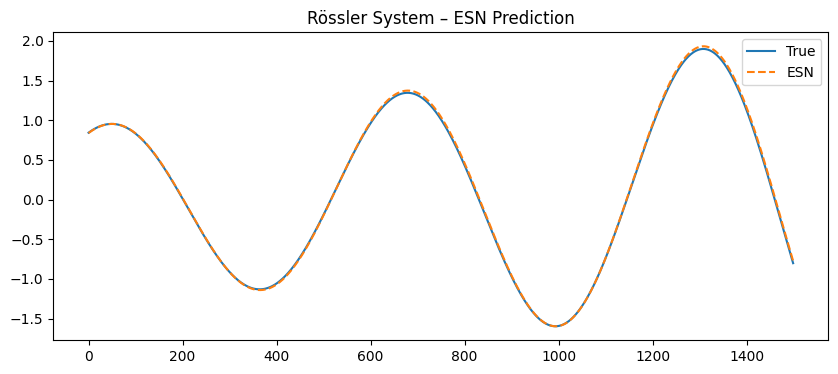

In [140]:
def rossler(x, dt, p):
    u, v, w = x
    a = p["a"]
    b = p["b"]
    c = p["c"]
    return np.array([-v - w, u + a * v, b + w * (u - c)])

result_pp = run_esn_on_system(
    system_name="Rössler System",
    system_rhs=rossler,
    x0=np.array([0.5, 0.5, 0.5]),
    params={
        "a":0.1,
        "b":0.1,
        "c":14
    },
    dt=0.01,
    T=5000,
    spinup=500,
    observed_idx=[0],   # prey + predator
    esn_kwargs=dict(
        N=1000,
        SR=0.8,
        density=0.05,
        alpha=0.3,
        sigma=0.4,
        beta=1e-8,
        random_state=42,
    ),
    forecast_steps=1500
)